# Implementing Nerual Networks Model to classify the given image into 1 of the 10 categories of the fashion MNIST dataset

## Step 1: Importing the dataset

In [26]:
path = r"C:\NumberMNIST"

print("Path to dataset files:", path)

Path to dataset files: C:\NumberMNIST


## Step 2: Importing necessary libraries and loading the dataset

In [27]:
import numpy as np
import struct
import os

def load_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

os.listdir(path) # List files in the dataset directory to verify paths


['t10k-images-idx3-ubyte',
 't10k-images.idx3-ubyte',
 't10k-labels-idx1-ubyte',
 't10k-labels.idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-images.idx3-ubyte',
 'train-labels-idx1-ubyte',
 'train-labels.idx1-ubyte']

In [28]:
X_train = load_images(path + r"\train-images.idx3-ubyte")
y_train = load_labels(path + r"\train-labels.idx1-ubyte")

X_test = load_images(path + r"\t10k-images.idx3-ubyte")
y_test = load_labels(path + r"\t10k-labels.idx1-ubyte")

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Train shape: (60000, 784)
Test shape: (10000, 784)
Train labels shape: (60000,)
Test labels shape: (10000,)


## Step 3: Data Preprocessing

**Flattening** is the process of converting a multi-dimensional input (such as a 2D image matrix) into a one-dimensional vector so that it can be fed into a fully connected neural network.

Here, flattening is the process of converting each 28×28 image into a 784-dimensional vector so that it can be used as input to a fully connected neural network.

**In this case, flattening images is not necessary as they are already in the shape (num_samples, 784)!**

In [29]:
np.min(X_train), np.max(X_train) # Check pixel value range

(0, 255)

In [30]:
# Normalize pixel values to [0, 1]
X_train= X_train / 255.0
X_test = X_test / 255.0

# Why 255.0? Because pixel values in the dataset are in the range [0, 255], 
# and dividing by 255.0 scales them to the range [0, 1], 
# which is beneficial for training neural networks.

In [31]:
print(f"Unique labels in y_train: {np.unique(y_train)}")

Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]


Neural network needs 0s and 1s, not other numbers, hence we one-hot encode the original labels

In [32]:
# One-hot encode labels

def one_hot_encode(y, num_classes):
    one_hot_matrix= np.zeros((y.shape[0], num_classes))
    for i in range(y.shape[0]):
        one_hot_matrix[i, y[i]] = 1
    return one_hot_matrix

y_train_encoded = one_hot_encode(y_train, 10)
y_test_encoded = one_hot_encode(y_test, 10)

print("One-hot encoded train labels shape:", y_train_encoded.shape)
print("One-hot encoded test labels shape:", y_test_encoded.shape)

One-hot encoded train labels shape: (60000, 10)
One-hot encoded test labels shape: (10000, 10)


**What One-Hot Encoding Does:**

If:

y = [2, 0, 3]
num_classes = 4


Then output becomes:

[[0 0 1 0]
[1 0 0 0]
[0 0 0 1]]

where index of each one in each 1-D array denotes the class (for eg., index 2 -> Class 2).

**-> One-hot encoding is required for computing cross-entropy loss in multi-class classification problems.**

Now initially, the shape of the labels were:

Train labels shape: (60000,)
Test labels shape: (10000,)

i.e., they were 1D array initally.

After one-hot encoding:

One-hot encoded train labels shape: (60000, 10)
One-hot encoded test labels shape: (10000, 10)


i.e., they are 2D matrices now.

Now the question is: **Why Do We Need 2D Matrices?**

It's because we are training on many samples at once, not one image at a time.

Neural networks use matrix multiplication to process batches efficiently.

In [33]:
# Quick dataset analysis

unique, counts = np.unique(y_train, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# zip() is a built-in Python function that lets you iterate over 
# multiple sequences (or lists) at the same time.

Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


Here, each class has around 6000 samples, hence the dataset is **mostly balanced**.

Before we move on to the next step, we have three options for training: 

1. Batch Gradient Descent (use all 60,000 samples at once)
2. Mini-Batch Gradient Descent (use small batches like 32/64/128)
3. Stochastic Gradient Descent (1 sample at a time)

We will pick the second one here because it has faster convergence, more stable than SGD and has better generalisation.

### Step 4: Implementing Mini-Batch Training

In [34]:
# Prevents learning bias by ensuring that the model sees a 
# balanced number of samples from each class during training.

# aragne(): Creates an array of indices from 
# 0 to the number of samples in X.
# Not to be confused with range(), which creates a list of integers.

def shuffle_data(X, Y):
    indices= np.arange(X.shape[0])
    np.random.shuffle(indices) # Shuffle the indices in place

    return X[indices], Y[indices]

**NOTE:** What's reproducibility? It means that if you run the code multiple times, you will get the same results each time. This is important for debugging and comparing results.

This is achieved by np.random.seed().

In [35]:
# Softmax function
def softmax(z):

    #keepdims=True keeps the dimensions of the output the same as the input,
    # which is important for broadcasting during division.

    # How? By subtracting the maximum value in each row of z from every element in that row,
    # we ensure that the largest value in each row becomes 0, and all other values become negative.

    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) # For numerical stability
    
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [36]:
# Relu activation function

def relu(z):
    return np.maximum(0, z)

In [37]:
# Forward propagation function

def forward_propagation(X, W1, b1, W2, b2):
    
    # Here, z1 represents the pre-activation output of the hidden layer,
    # which is calculated by performing a linear transformation 
    # on the input batch (X_batch)

    z1= np.dot(X, W1) + b1 # Linear transformation for hidden layer
            
    a1= relu(z1) # Calling relu() for hidden layer

    # z2 represents the pre-activation output of the output layer, 
    # which is calculated by performing a linear transformation on 
    # the activated hidden layer(a1)

    z2= np.dot(a1, W2) + b2 # Linear transformation for output layer

    # Calling softmax on z2 converts the raw output scores into probabilities
    # that sum to 1 across the output classes.

    a2= softmax(z2) # Softmax activation for output layer

    return a1, a2

In [38]:
# Defining categorical cross-entropy loss function

def cat_cross_entropy_loss(m, y_batch, a2):
    # m is the number of samples in the batch
    # y_batch is the true one-hot encoded labels for the batch
    # a2 is the predicted probabilities from the output layer

    # Adding a small epsilon to prevent log(0)
    epsilon = 1e-8

    # Calculate the loss using the categorical cross-entropy formula
    loss = -np.sum(y_batch * np.log(a2 + epsilon)) / m

    return loss

In [39]:
# Defining backward propagation function

def back_prop(a1, a2, X_batch, y_batch, m, w2, z1):

    dZ2= a2 - y_batch # Gradient of loss wrt z2 (output layer pre-activation)
    
    dW2= np.dot(a1.T, dZ2) / m # Gradient of loss wrt to W2
    db2= np.sum(dZ2, axis=0, keepdims=True) / m # Gradient of loss wrt b2

    dA1= np.dot(dZ2, w2.T) # Gradient of loss wrt a1 (hidden layer activation)
    dZ1= dA1 * (z1 > 0)     # Gradient of loss wrt z1 (hidden layer pre-activation), applying ReLU derivative

    dW1= np.dot(X_batch.T, dZ1) / m # Gradient of loss wrt W1
    db1= np.sum(dZ1, axis= 0, keepdims= True) / m # Gradient of loss wrt b1

    return dW1, db1, dW2, db2

**NOTE:** The activated output of the hidden layer represents learned feature transformations, whereas the output layer produces class probabilities via the softmax function, which are used for final classification.

In [40]:
# Training function

def train(batch_size, epochs, lr):

    input_size= X_train.shape[1] # 784 for 28x28 images
    output_size= y_train_encoded.shape[1] # 10 for 10 classes (0 - 9)

    # He initialisation for weights (important for ReLU activation)
    np.random.seed(100) # Ensure reproducibility

    W1= np.random.randn(input_size, 100) * np.sqrt(2 / input_size) # 100 neurons in hidden layer
    b1= np.zeros((1, 100)) # Bias for hidden layer

    W2= np.random.randn(100, output_size) * np.sqrt(2 / 100) # Output layer weights
    b2= np.zeros((1, output_size)) # Bias for output layer

    history= [] # To store loss history

    for epoch in range(epochs):

        # Shuffle training data at the beginning of each epoch
        indices= np.random.permutation(X_train.shape[0]) # Shuffled indices for the entire dataset

        X_train_shuffled= X_train[indices]
        y_train_shuffled= y_train_encoded[indices]

        epoch_loss= 0

        for i in range(0, X_train.shape[0], batch_size):

            X_batch= X_train_shuffled[i: i + batch_size]
            y_batch= y_train_shuffled[i: i+ batch_size]

            # Calling forward_propagation() to get activations
            a1, a2= forward_propagation(X_batch, W1, b1, W2, b2)

            # Here, 
            
            # a1: The activated output of the hidden layer, 
            # which is used in backpropagation to compute gradients for the 
            # weights and biases of both layers.

            # a2: The predicted probabilities from the output layer, 
            # which is used to calculate gradients in backpropagation.

            # Calculate loss for the current batch
            epoch_loss += cat_cross_entropy_loss(X_batch.shape[0], y_batch, a2)

            # Now, forward propagation computes predictions and computes loss
            # but it DOES NOT UPDATE WEIGHTS! It only answers: 
            # "GIVEN current weights, what is the prediction?"

            # Hence we need back prop as well

            # Calling back_prop() to compute gradients
            dW1, db1, dW2, db2= back_prop(a1, a2, X_batch, y_batch, X_batch.shape[0], W2, np.dot(X_batch, W1) + b1)

            # Update weights and biases using gradient descent
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2

        history.append(epoch_loss / (X_train.shape[0] / batch_size)) # Average loss per epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {history[-1]:.4f}")

    return W1, b1, W2, b2, history

### Step 5: Predicting and Evaluating

Training with batch size 32
Epoch 1/40, Loss: 0.6515
Epoch 2/40, Loss: 0.3436
Epoch 3/40, Loss: 0.2982
Epoch 4/40, Loss: 0.2702
Epoch 5/40, Loss: 0.2483
Epoch 6/40, Loss: 0.2302
Epoch 7/40, Loss: 0.2141
Epoch 8/40, Loss: 0.2004
Epoch 9/40, Loss: 0.1880
Epoch 10/40, Loss: 0.1772
Epoch 11/40, Loss: 0.1679
Epoch 12/40, Loss: 0.1591
Epoch 13/40, Loss: 0.1512
Epoch 14/40, Loss: 0.1444
Epoch 15/40, Loss: 0.1379
Epoch 16/40, Loss: 0.1322
Epoch 17/40, Loss: 0.1267
Epoch 18/40, Loss: 0.1221
Epoch 19/40, Loss: 0.1175
Epoch 20/40, Loss: 0.1132
Epoch 21/40, Loss: 0.1092
Epoch 22/40, Loss: 0.1057
Epoch 23/40, Loss: 0.1021
Epoch 24/40, Loss: 0.0990
Epoch 25/40, Loss: 0.0958
Epoch 26/40, Loss: 0.0932
Epoch 27/40, Loss: 0.0903
Epoch 28/40, Loss: 0.0880
Epoch 29/40, Loss: 0.0855
Epoch 30/40, Loss: 0.0832
Epoch 31/40, Loss: 0.0810
Epoch 32/40, Loss: 0.0790
Epoch 33/40, Loss: 0.0770
Epoch 34/40, Loss: 0.0751
Epoch 35/40, Loss: 0.0731
Epoch 36/40, Loss: 0.0716
Epoch 37/40, Loss: 0.0700
Epoch 38/40, Loss: 

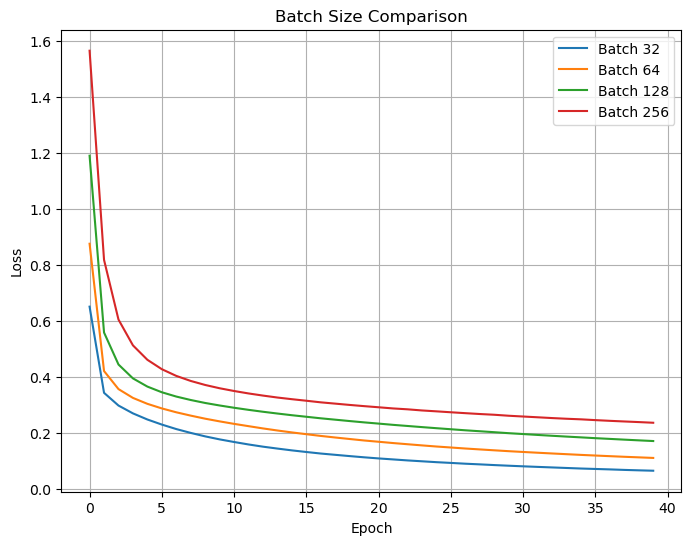

In [42]:
# Checking which batch size best suits our model

import matplotlib.pyplot as plt

batch_sizes= [32, 64, 128, 256]
results= {}

for bs in batch_sizes:
    print(f"Training with batch size {bs}")
    W1, b1, W2, b2, history= train(bs, epochs=40, lr=0.01)
    
    results[bs] = {"history": history, "W1": W1, "b1": b1, "W2": W2, "b2": b2}

plt.figure(figsize=(8,6))

for bs in batch_sizes:
    plt.plot(results[bs]["history"], label=f"Batch {bs}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Batch Size Comparison")
plt.legend()
plt.grid(True)
plt.show()


**Conclusion from the graph:**

From the graph, **batch size = 32** is the most suitable choice because: 

1. It consistently achieves the lowest training loss across all epochs and converges faster than the other batch sizes.

2. Its curve shows a steep initial drop (indicating efficient learning early on) and continues to decrease smoothly without instability, suggesting both strong optimization and stable gradient updates.

3. In contrast, larger batch sizes like 128 and 256 converge more slowly and settle at higher final loss values, indicating less effective learning under the same number of epochs. 

4. Since batch size 32 provides faster convergence and the best final loss while remaining stable, it represents the best trade-off between learning efficiency and performance in this experiment.


### Step 6: Evaluating our Model

In [43]:
best_model= results[32]

W1= best_model["W1"]
b1= best_model["b1"]
W2= best_model["W2"]
b2= best_model["b2"]

In [44]:
a1_best, a2_best= forward_propagation(X_test, W1, b1, W2, b2)

In [45]:
a1_best

array([[0.        , 0.94855825, 0.        , ..., 1.98385807, 0.        ,
        1.837493  ],
       [0.28673772, 2.07137646, 0.        , ..., 0.        , 0.9417829 ,
        0.        ],
       [0.87260579, 0.34356842, 0.        , ..., 0.        , 0.59408195,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.90440627, 0.        ,
        1.01459698],
       [1.45881254, 1.21768286, 0.        , ..., 2.03602757, 0.        ,
        0.77982388],
       [0.        , 0.18708033, 0.22073219, ..., 0.        , 0.64835319,
        0.61564781]])

In [46]:
a2_best

array([[2.45372867e-06, 1.24645780e-07, 1.03047023e-04, ...,
        9.99229777e-01, 4.96120402e-06, 2.58209991e-05],
       [3.40532789e-05, 1.57511549e-04, 9.98705903e-01, ...,
        8.73491602e-12, 8.25502895e-04, 8.64513321e-11],
       [2.63357130e-05, 9.93058360e-01, 1.21429363e-03, ...,
        1.40681906e-03, 2.52335360e-03, 1.12799443e-04],
       ...,
       [6.18095336e-10, 5.27505503e-09, 1.37105653e-08, ...,
        3.88187492e-05, 7.75843968e-05, 2.76566288e-04],
       [4.49704493e-06, 4.34695593e-07, 6.22719956e-08, ...,
        1.57822519e-07, 1.39837088e-03, 1.01716779e-07],
       [1.74790089e-07, 1.13021219e-09, 1.11588725e-06, ...,
        1.86405150e-11, 2.82620885e-09, 1.41359507e-10]])

In [47]:
# Computing test accuracy


predictions= np.argmax(a2_best, axis=1) # Get predicted class labels
accuracy= np.mean(predictions == y_test) * 100

# Why mean? Because np.mean() calculates the average of the boolean array (predictions == y_test), 
# which gives us the proportion of correct predictions. 
# Multiplying by 100 converts this proportion into a percentage

print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 97.47%


**NOTE:** argmax(): This function returns the indices of the maximum values along a specified axis. 

In this case, axis=1 means we want to find the index of the maximum value in each row of a2_best, which corresponds to the predicted class label for each test sample.

In [51]:
# Confusion matrix

# Using traditional code

conf_matrix = np.zeros((10, 10), dtype=int)

for i in range(len(y_test)):
    conf_matrix[y_test[i], predictions[i]] += 1

print("Confusion Matrix:")
print(conf_matrix)
print("\nDimensions of confusion matrix:", conf_matrix.shape)

Confusion Matrix:
[[ 970    0    1    1    0    4    1    2    1    0]
 [   0 1125    3    0    0    1    2    1    3    0]
 [   4    1 1011    2    2    0    1    7    4    0]
 [   0    0    7  985    0    4    0    6    6    2]
 [   2    0    3    1  953    0    3    3    2   15]
 [   4    1    0    9    1  864    6    1    5    1]
 [   5    3    0    1    3    7  934    1    4    0]
 [   1    6   14    1    1    1    0  996    0    8]
 [   4    0    5    6    4    4    4    5  941    1]
 [   3    5    1    8   10    3    2    5    4  968]]

Dimensions of confusion matrix: (10, 10)


- The confusion matrix is a 10×10 table that summarizes the model’s classification performance.

- Each row represents the actual digit class, and each column represents the predicted class. 

- The diagonal elements indicate correct predictions, while off-diagonal elements represent misclassifications.

- The strong diagonal dominance shows that the model correctly classifies most test samples, with only minor confusion between certain digit classes.

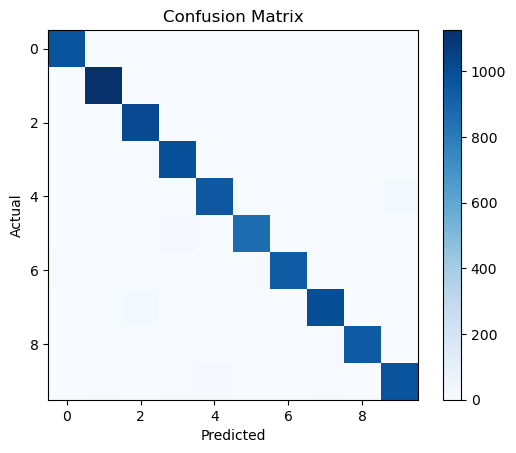

In [49]:
# Using matplotlib

plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- The heatmap visually represents the confusion matrix using color intensity, where darker shades indicate higher values.

- Rows correspond to actual classes and columns to predicted classes. The prominent dark diagonal confirms high classification accuracy, while lighter off-diagonal areas indicate relatively few misclassifications. 

This visualisation provides an intuitive overview of the model’s performance across all digit categories.

In [ ]:
recall = []

for i in range(10):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    recall_i = TP / (TP + FN)
    recall.append(recall_i)

print("Recall per class:", dict(enumerate(recall)))
print("Macro Recall:", np.mean(recall))

# Macro recall is the average of the recall values for each class, 
# giving equal weight to each class regardless of its frequency in the dataset.

Recall per class: {0: 0.9897959183673469, 1: 0.9911894273127754, 2: 0.9796511627906976, 3: 0.9752475247524752, 4: 0.9704684317718941, 5: 0.968609865470852, 6: 0.9749478079331941, 7: 0.9688715953307393, 8: 0.9661190965092402, 9: 0.9593657086223984}
Macro Recall: 0.9744266538861612


In [54]:
precision = []
recall = []
f1 = []

for i in range(10):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP

    precision_i = TP / (TP + FP)
    recall_i = TP / (TP + FN)

    f1_i = 2 * precision_i * recall_i / (precision_i + recall_i)

    precision.append(precision_i)
    recall.append(recall_i)
    f1.append(f1_i)

print("Precision per class:", dict(enumerate(precision)))
print("Macro Precision:", np.mean(precision))
print("F1-score per class:", f1)
print("Macro F1-score:", np.mean(f1))

# Similar to macro recall, macro precision is the average of the precision values for each class
# while macro F1-score is the average of the F1-scores for each class, 
# both giving equal weights to each class regardless of its frequency in the dataset.


Precision per class: {0: 0.9768378650553877, 1: 0.985977212971078, 2: 0.9674641148325359, 3: 0.9714003944773175, 4: 0.9784394250513347, 5: 0.972972972972973, 6: 0.9800629590766002, 7: 0.9698149951314509, 8: 0.9701030927835051, 9: 0.9728643216080402}
Macro Precision: 0.9745937353960222
F1-score per class: [0.9832742017232641, 0.9885764499121265, 0.9735194992778046, 0.9733201581027668, 0.9744376278118609, 0.9707865168539327, 0.9774986917844061, 0.9693430656934306, 0.9681069958847737, 0.966067864271457]
Macro F1-score: 0.9744931071315823


### Conclusion

The neural network achieved strong performance on the MNIST dataset, with an overall accuracy of approximately 97.4% and a macro F1-score of 0.9745. 

Precision and recall values are consistently high across all digit classes, indicating balanced and reliable classification. 

The confusion matrix shows strong diagonal dominance with minimal off-diagonal values, confirming that most predictions are correct and class-wise confusion is low. 

Overall, the model generalises well to unseen data and demonstrates effective learning and stable optimisation.